In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import sqlite3
import pandas as pd
from lsst.sims.utils import hpid2RaDec

In [2]:
# Connect to the database, set a directory to hold all the output
dbFile = 'euclid_ditherv1.6.1_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint fielddec > -52 and fieldDec < -44 and fieldRA > 52 and fieldRA < 69 and filter="g" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'night']
Found 3221 visits
Running:  ['opsim_CoaddM5_fielddec_gt_-52_and_fieldDec_lt_-44_and_fieldRA_gt_52_and_fieldRA_lt_69_and_g_HEAL', 'opsim_Count_night_fielddec_gt_-52_and_fieldDec_lt_-44_and_fieldRA_gt_52_and_fieldRA_lt_69_and_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "fielddec > -52 and fieldDec < -44 and fieldRA > 52 and fieldRA < 69 and filter="g"" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: -252.433  dipole: lon: 60.5796, lat: -48.1114, amp: 280.463
  mono, lon, lat, amp
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 231 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: -81713.9  dipole: lon: 60.7605, lat: -48.1999, amp: 82250.3
  mono, lon, lat, amp


Plotting complete.


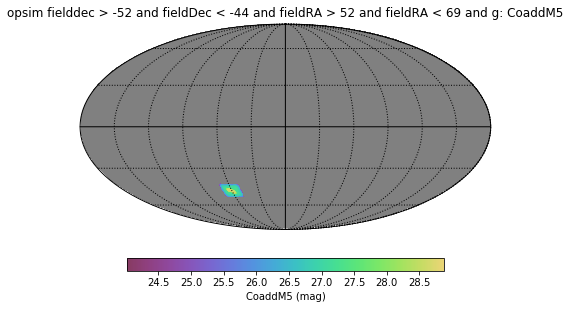

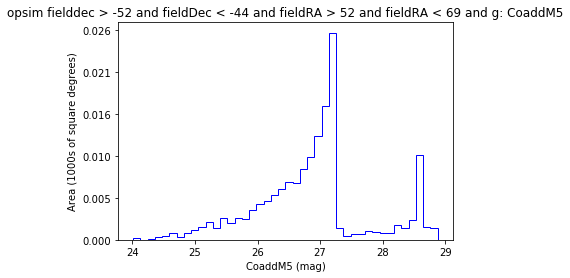

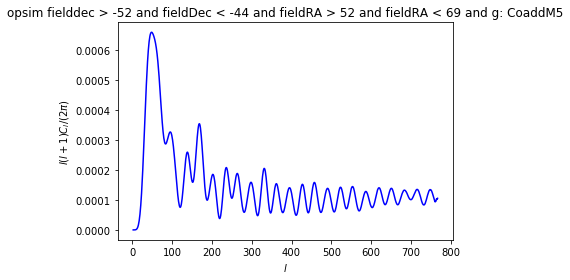

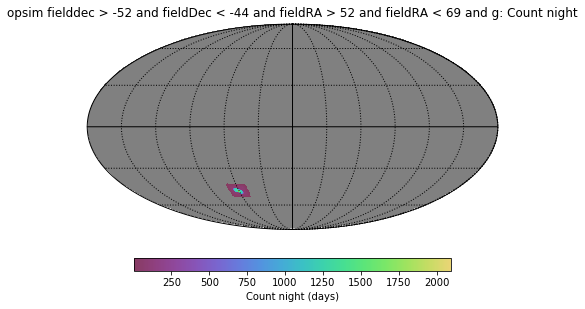

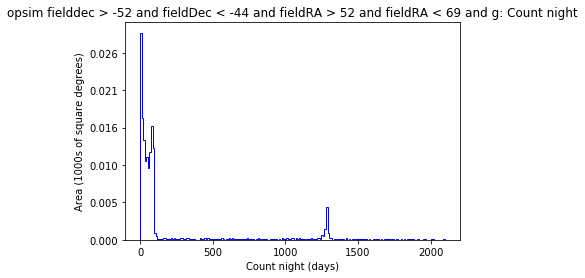

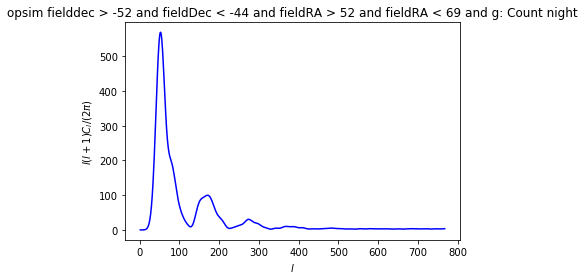

In [3]:
bundleList = []
# Need to set a single filter in the sql query, coadding different filters doesn't make sense
sql = 'fielddec > -52 and fieldDec < -44 and fieldRA > 52 and fieldRA < 69 and filter="g"'
metric = metrics.Coaddm5Metric()
slicer = slicers.HealpixSlicer(nside=256)
summaryStats = [metrics.MedianMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))

metric=metrics.CountMetric(col='night')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))


bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)



/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 76.1516621949687 103.8483378050313 -13.848337805031301 13.848337805031301
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 3 deg 0.00'.
  vdeg, varcmin
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 1 deg 0.00'.
  vdeg, varcmin


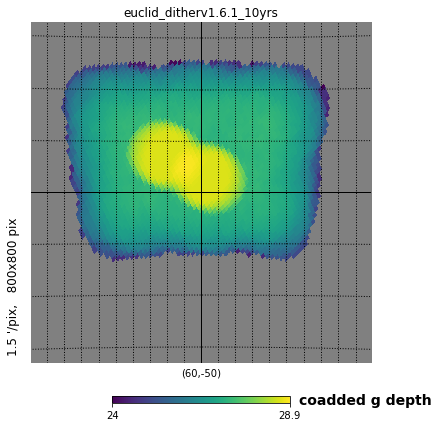

In [4]:
hp.gnomview(bundleList[0].metricValues, rot=(60, -50),
            xsize=800, ysize=800, unit='coadded g depth',
            title='euclid_ditherv1.6.1_10yrs')
hp.graticule()
plt.savefig('directional_dither.pdf')

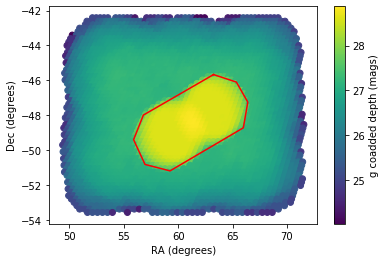

In [5]:
hpids = np.arange(bundleList[0].metricValues.size)
ra, dec = hpid2RaDec(slicer.nside, hpids)
octogon=np.array(np.array([[63.25, -45.67],
[65.35, -46.10],
[66.40, -47.25],
[65.99, -48.72],
[59.25, -51.19],
[56.95, -50.82],
[55.90, -49.40],
[56.80, -47.99],
[63.25, -45.67] ]))

plt.plot(octogon[:,0], octogon[:,1], 'r')

plt.scatter(ra, dec, c=bundleList[0].metricValues)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
cb = plt.colorbar()
cb.set_label('g coadded depth (mags)')
plt.savefig('euclid_coadd.png')

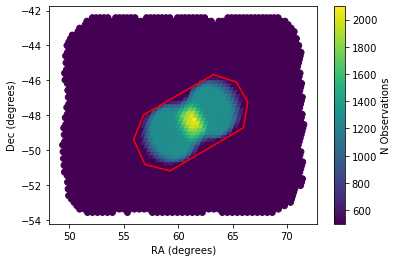

In [6]:
plt.plot(octogon[:,0], octogon[:,1], 'r')

plt.scatter(ra, dec, c=bundleList[1].metricValues, vmin=500)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
cb = plt.colorbar()
cb.set_label('N Observations')
#plt.xlim([55,67])
#plt.ylim([-52,-45])
plt.savefig('euclid_nvis.png')

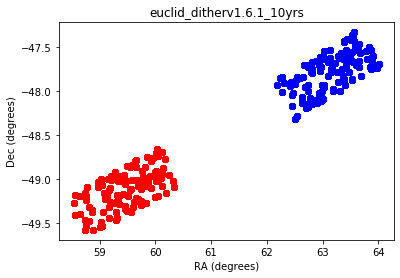

In [7]:
conn = sqlite3.connect('euclid_ditherv1.6.1_10yrs.db')
df = pd.read_sql('select fieldRA,fieldDec,note from summaryallprops where note like "DD:EDFS%"', conn)
good = np.where(df['note'].values=='DD:EDFS, a')
plt.plot(df['fieldRA'].values[good], df['fieldDec'].values[good], 'ro')

good = np.where(df['note'].values=='DD:EDFS, b')
plt.plot(df['fieldRA'].values[good], df['fieldDec'].values[good], 'bo')

plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('euclid_ditherv1.6.1_10yrs')
plt.savefig('dither_positions.png')

In [8]:
conn = db.OpsimDatabase(dbFile)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint fielddec > -52 and fieldDec < -44 and fieldRA > 52 and fieldRA < 69 and filter="g" for columns ['fiveSigmaDepth', 'rotSkyPos', 'observationStartMJD', 'fieldDec', 'fieldRA']
Found 3221 visits
Running:  ['opsim_CoaddM5_fielddec_gt_-52_and_fieldDec_lt_-44_and_fieldRA_gt_52_and_fieldRA_lt_69_and_g_HEAL']


/Users/yoachim/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/DarwinX86/sims_coordUtils/2.13.0.sims-5-gac68177+c8ac31f2ca/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.019397491906 -0.020523312336

  category=MultipleChipWarning)
/Users/yoachim/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/DarwinX86/sims_coordUtils/2.13.0.sims-5-gac68177+c8ac31f2ca/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coo

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "fielddec > -52 and fieldDec < -44 and fieldRA > 52 and fieldRA < 69 and filter="g"" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: -251.479  dipole: lon: 60.58, lat: -48.1199, amp: 279.458
  mono, lon, lat, amp


Plotting complete.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 76.1516621949687 103.8483378050313 -13.848337805031301 13.848337805031301
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 3 deg 0.00'.
  vdeg, varcmin
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 1 deg 0.00'.
  vdeg, varcmin


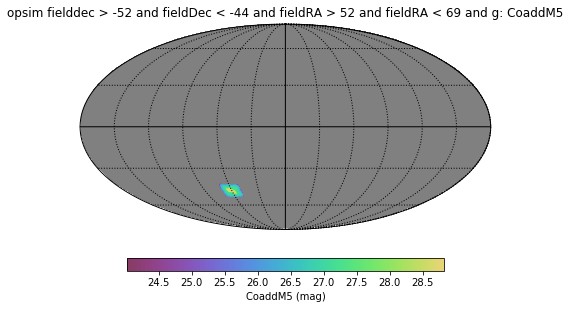

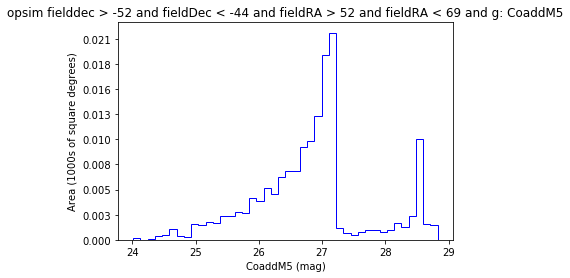

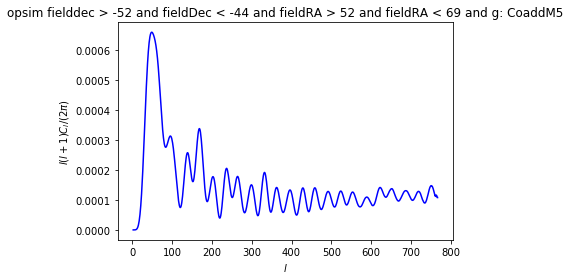

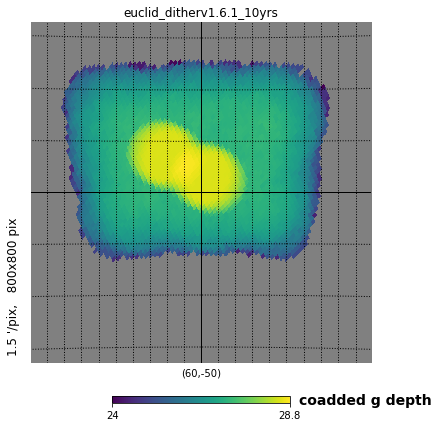

In [7]:
# Do it again with chip gaps on

bundleList = []
# Need to set a single filter in the sql query, coadding different filters doesn't make sense
sql = 'fielddec > -52 and fieldDec < -44 and fieldRA > 52 and fieldRA < 69 and filter="g"'
metric = metrics.Coaddm5Metric()
slicer = slicers.HealpixSlicer(nside=256, useCamera=True, useCache=False)
summaryStats = [metrics.MedianMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

hp.gnomview(bundleList[0].metricValues, rot=(60, -50),
            xsize=800, ysize=800, unit='coadded g depth',
            title='euclid_ditherv1.6.1_10yrs')
hp.graticule()